# VAE attempt 3
Based off of Alexander Van de Kleut's work. See [this post](https://avandekleut.github.io/vae/) for some theory and explination.

In [1]:
import torch; torch.manual_seed(0)
import json
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt;
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
### Paths ###

parent_folder = 'C:/Users/Aidan/Documents/Winter_2023/BE177B/Code/'
art_json = parent_folder + 'wonglab-capstone/Datateam/Artificial_imset/artificial_kymographs.json'
exp_json = parent_folder + 'wonglab-capstone/Datateam/imset1/experimental_kymograph.json'

class ArtKymoDataset(Dataset):
    def __init__(self):
        #data loading
        with open(art_json, 'r') as f:
            kymos = np.asarray(json.loads(f.read())["kymoset"])
        kymos = kymos.astype('float32')
        kymos = torch.from_numpy(kymos)
        # self.x = kymos[:,None,:,:]
        self.x = kymos
        self.x = self.x[:,None,:,:]
        self.n_samples = kymos.shape[0]

    def __getitem__(self, index):
        return self.x[index,:,:]

    def __len__(self):
        return self.n_samples

### Autoencoder architecture, notice this is **NOT** a VAE

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(1200, 512) # input flattened kymograph
        self.linear2 = nn.Linear(512, latent_dims) # squishes into latent space
    
    def forward(self, x):
        x = torch.flatten(x, start_dim = 0) #may have to change start dim if not along right axis, I guessed randomly
        x = F.relu(self.linear2(F.relu(self.linear1(x))))
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 20, 60))

class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

#### Pretty good training loop, can probably repurpose for VAE as well

In [4]:
def train(autoencoder, lr, data, epochs=10):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        startTime = time.perf_counter()
        overall_loss = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            loss.backward()
            overall_loss += loss.item()
            opt.step()
        timediff = (time.perf_counter()-startTime)
        print("\tEpoch {} complete \tTotal Loss: {} \tTraining time: {} ".format(epoch+1, loss, timediff))
    return autoencoder

In [6]:
dataset = ArtKymoDataset()
latent_dims = 10
learning_rate = 1e-5 #his seems to be sweet spot, can try experimenting more though
autoencoder = Autoencoder(latent_dims).to(device)
autoencoder = train(autoencoder, lr=learning_rate, data=dataset, epochs=10)

### Variational Autoencoder

In [7]:
class Kymo_VE(nn.Module):
    def __init__(self, latent_dims):
        super(Kymo_VE, self).__init__()
        self.linearInput = nn.Linear(1200,512)
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256,256)
        self.linearMu = nn.Linear(256, latent_dims)
        self.linearSigma = nn.Linear(256, latent_dims)

        self.Normal = torch.distributions.Normal(0,1)
        self.KLDivergence = 0 #Kullback–Leibler divergence

    def forward(self, x):
        x = torch.flatten(x, start_dim=0) #again, might have to change later, not sure if this should be 0 or 1
        x = F.relu(self.linearInput(x))
        x = F.relu(self.linear2(F.relu(self.linear1(x))))
        mu = self.linearMu(x)
        sigma = torch.exp(self.linearSigma(x))
        z = mu + sigma*self.Normal.sample(mu.shape)
        self.KLDivergence = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z

class VE_Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(VE_Decoder, self).__init__()
        self.linearLatent = nn.Linear(latent_dims, 256)
        self.linear1 = nn.Linear(256,256)
        self.linear2 = nn.Linear(256, 512)
        self.linear3 = nn.Linear(512, 1200)

    def forward(self, z):
        z = F.relu(self.linearLatent(z))
        z = F.relu(self.linear2(F.relu(self.linear1(z))))
        z = torch.sigmoid(self.linear3(z))
        return z.reshape((-1, 1, 20, 60))

class Kymo_VAE(nn.Module):
    def __init__(self, latent_dims):
        super(Kymo_VAE, self).__init__()
        self.encoder = Kymo_VE(latent_dims)
        self.decoder = VE_Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


#### VAE Training Loop

In [8]:
def trainVAE(autoencoder, lr, data, epochs=10, tol = 1000):
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    data_len = len(data)
    past_loss = 0
    for epoch in range(epochs):
        startTime = time.perf_counter()
        loss_count = 0
        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.KLDivergence
            loss.backward()
            loss_count += loss.item()
            opt.step()
        timediff = (time.perf_counter()-startTime)
        print("\tEpoch {} complete \tAverage Loss: {:.3f} \tTraining time: {:.3f} ".format(epoch+1, loss_count/data_len, timediff))
        if abs(past_loss-loss_count) < tol:
            print("\nModel learning below cutoff: {}\nTerminating model training...".format(tol))
            return autoencoder
        past_loss = loss_count
    return autoencoder

In [9]:
# run the training loop
VAE = Kymo_VAE(latent_dims=2).to(device)
VAE = trainVAE(VAE, lr=learning_rate, data=dataset, epochs=100)

	Epoch 1 complete 	Average Loss: 180384.251 	Training time: 4.327 
	Epoch 2 complete 	Average Loss: 171509.954 	Training time: 4.761 
	Epoch 3 complete 	Average Loss: 170476.189 	Training time: 6.058 
	Epoch 4 complete 	Average Loss: 170258.224 	Training time: 6.783 
	Epoch 5 complete 	Average Loss: 170102.491 	Training time: 6.570 
	Epoch 6 complete 	Average Loss: 169997.569 	Training time: 6.249 
	Epoch 7 complete 	Average Loss: 169924.561 	Training time: 6.264 
	Epoch 8 complete 	Average Loss: 169880.896 	Training time: 6.406 
	Epoch 9 complete 	Average Loss: 169849.643 	Training time: 6.310 
	Epoch 10 complete 	Average Loss: 169829.185 	Training time: 6.895 
	Epoch 11 complete 	Average Loss: 169814.682 	Training time: 6.798 
	Epoch 12 complete 	Average Loss: 169802.926 	Training time: 6.546 
	Epoch 13 complete 	Average Loss: 169794.680 	Training time: 6.408 
	Epoch 14 complete 	Average Loss: 169788.765 	Training time: 6.387 
	Epoch 15 complete 	Average Loss: 169784.606 	Training ti

In [52]:
# plot the first two latent dimensions of the encoded kymographs
def plot_latent(autoencoder, data):
    for i, x in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[0], z[1])

#pick random kymographs to reconstruct and show
def plot_sample_im(autoencoder, data):
    plt.figure(figsize=(12,5))
    for i in range(6):
        idz = np.random.randint(0,len(data))
        z = autoencoder(data[idz].to(device))
        z = z.to('cpu').detach().numpy()
        plt.subplot(2,3,i+1)
        plt.xlabel('Time')
        plt.ylabel('Axis Position')
        plt.imshow(z[0,0,:,:], cmap='gray')
    plt.tight_layout()
    plt.show()

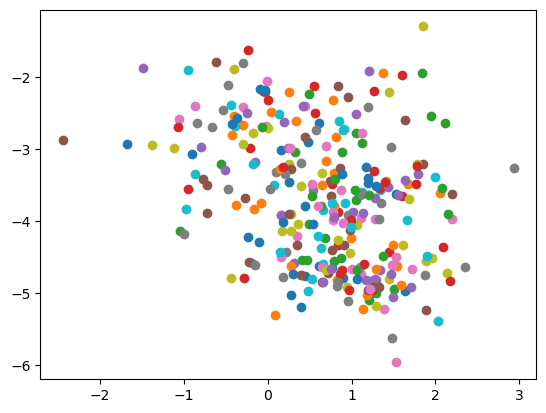

In [46]:
plot_latent(VAE, dataset)

We can see that the VAE is not doing a very good job at producing meaningful results...

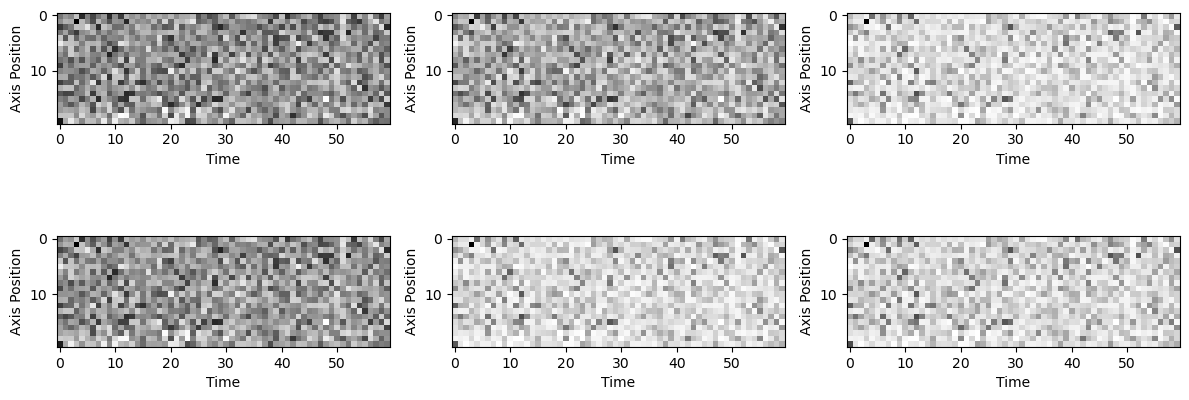

In [51]:
# Sample reconstructed kymographs
plot_sample_im(VAE, dataset)